<a href="https://colab.research.google.com/github/rberbenkova/lab-lora-tuning-peft/blob/main/lab-lora-tuning-peft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

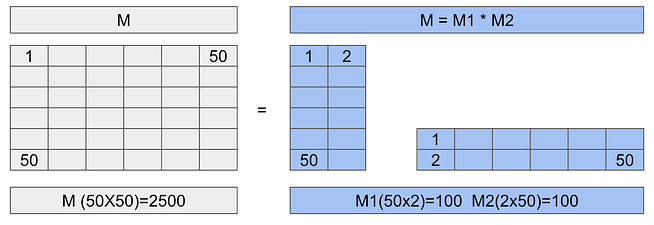

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [11]:
# !pip install -q peft==0.8.2
# !pip install -q datasets==2.16.1
#!pip install ipywidgets==7.7.5

In [12]:
!pip -q install -U transformers datasets peft accelerate bitsandbytes sentencepiece evaluate

In [13]:
!pip -q uninstall -y cudf-cu12 pylibcudf-cu12 dask-cudf-cu12 rmm-cu12
# (optional) clean up any leftover RAPIDS metapackages too



In [14]:
!pip -q install -U "transformers>=4.44.0" "accelerate>=0.34.0" "peft>=0.13.0" "bitsandbytes>=0.44.0"
# If you had RAPIDS earlier and saw a pyarrow conflict, keep RAPIDS happy:
# !pip -q install --upgrade --force-reinstall "pyarrow<20"


From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [15]:
# 1) Load tokenizer + model (decoder-only, 4-bit)
import torch # used by Transformers/PEFT under the hood (tensor ops, dtypes, device)
from transformers import AutoModelForCausalLM, AutoTokenizer
# generic loaders that pick the right model/tokenizer classes from the Hub
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
# PEFT helpers to configure and wrap the base model with the LoRA adapters

# A good starter causal model for Colab:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"   # <= replace with another *valid* HF id if you like
# a 1.1B parameter, decoder -only chat model, small enough to fit on a T4 when quantized (4 bit)

#2  Tokenizer (LEFT padding for decoder-only!)
# ----------------
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True,
    padding_side="left",  # <— important for decoder-only
)
if tokenizer.pad_token is None and tokenizer.eos_token is not None:
    tokenizer.pad_token = tokenizer.eos_token

# 3) # Use fp16 on GPU, fp32 on CPU
dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# 4) Loading full-precision weights (no quantization)
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=dtype,
    device_map="auto",   #  on GPU if available
)

# Memory-friendly training tweaks
base_model.gradient_checkpointing_enable()
base_model.config.use_cache = False   # required when using gradient checkpointing
model = base_model  # keep name 'model' for downstream calls



## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [16]:
import torch

# Ensure left padding for decoder-only models
tokenizer.padding_side = "left"
if tokenizer.pad_token is None and tokenizer.eos_token is not None:
    tokenizer.pad_token = tokenizer.eos_token

COACH_SYSTEM = (
    "You are Momentum, a supportive, evidence-informed motivational coach.\n"
    "Style: warm, concise, practical. Avoid fluff. No medical/mental-health diagnosis.\n"
    "Do:\n"
    "- Reflect back the goal in 1 line.\n"
    "- Offer 3–5 specific, doable steps with time estimates when helpful.\n"
    "- Reframe obstacles and propose a tiny first action.\n"
    "- Ask at most 1 clarifying question at the end.\n"
    "Tone: encouraging but not saccharine. Keep outputs ≤ 180 words.\n"
    "End with: 'Next step: <one tiny action>'."
)

def _build_prompt_string(tokenizer, system_text: str, user_text: str, max_len: int = 1024) -> str:
    """
    Return a SINGLE string prompt.
    Prefer the chat template if present, but request a STRING (tokenize=False).
    """
    if getattr(tokenizer, "chat_template", None):
        # Ask the tokenizer to format but not tokenize
        return tokenizer.apply_chat_template(
            [{"role": "system", "content": system_text},
             {"role": "user",   "content": user_text}],
            add_generation_prompt=True,
            tokenize=False,          # <-- key: return a string, not a tensor
        )
    # Fallback plain format
    return f"{system_text}\n{user_text}"

def generate_coach(
    model, tokenizer,
    user_goal: str, context: str | None = None,
    max_new_tokens: int = 180,
    temperature: float = 0.7,
    top_p: float = 0.9,
    do_sample: bool = True,
):
    # Build user message content
    user_text = f"User goal:\n{user_goal}"
    if context:
        user_text += f"\nContext:\n{context}"
    user_text += "\nCoach response:"

    # Build a string prompt (never a tensor)
    prompt_str = _build_prompt_string(tokenizer, COACH_SYSTEM, user_text)

    # Tokenize to a DICT (input_ids + attention_mask)
    batch = tokenizer(
        prompt_str,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=1024,
    )

    # Guard pad/eos ids
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    if "attention_mask" not in batch or batch["attention_mask"] is None:
        batch["attention_mask"] = (batch["input_ids"] != tokenizer.pad_token_id).long()

    # Move to device and record prompt length for echo slicing
    batch = {k: v.to(model.device) for k, v in batch.items()}
    input_len = batch["input_ids"].shape[1]

    gen_kwargs = dict(
        max_new_tokens=max_new_tokens,
        do_sample=do_sample,
        temperature=temperature,
        top_p=top_p,
        repetition_penalty=1.15,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        return_dict_in_generate=True,
        use_cache=True,
    )

    with torch.no_grad():
        out = model.generate(**batch, **gen_kwargs)

    # Remove the prompt from the decoded text
    gen_tokens = out.sequences[:, input_len:]
    text = tokenizer.batch_decode(gen_tokens, skip_special_tokens=True)[0].strip()
    return text

def generate_coach_greedy(
    model, tokenizer, user_goal: str, context: str | None = None, max_new_tokens: int = 180
):
    return generate_coach(
        model, tokenizer, user_goal, context,
        max_new_tokens=max_new_tokens,
        temperature=1.0, top_p=1.0,
        do_sample=False,   # deterministic baseline
    )


In [17]:
examples = [
    dict(user_goal="Get back to the gym 3x/week",
         context="I stopped after an injury and feel intimidated returning."),
    dict(user_goal="Finish my thesis introduction",
         context="I procrastinate and keep rewriting the first paragraph."),
    dict(user_goal="Wake up earlier",
         context="I snooze a lot and scroll late at night."),
    dict(user_goal="Apply to two jobs this week",
         context=None),
]

print("=== SAMPLING (temperature=0.7, top_p=0.9) ===")
for ex in examples:
    print("\nPROMPT:", ex)
    print("RESPONSE:\n", generate_coach(model, tokenizer, **ex))

print("\n\n=== DETERMINISTIC (greedy) ===")
for ex in examples:
    print("\nPROMPT:", ex)
    print("RESPONSE:\n", generate_coach_greedy(model, tokenizer, **ex))



=== SAMPLING (temperature=0.7, top_p=0.9) ===

PROMPT: {'user_goal': 'Get back to the gym 3x/week', 'context': 'I stopped after an injury and feel intimidated returning.'}
RESPONSE:
 To get back to the gym three times per week as requested, here's how you can refocus your approach using my coaching style template:

Step 1: Reflect on Goal
As the coach, it's important that you reflect on why you want to achieve this goal. Do you want to feel better physically or mentally? Are there any specific issues or challenges you're facing that need addressing? Use this reflection to inform your next steps.

Step 2: Offer Specific Steps
Instead of simply asking "How many days per week should I go?" ask instead, "What specific actions will help me reach my target number of days per week?" This creates clarity around what needs to be done rather than just telling someone how much they have to do.

Step 3: Provide Time Estim

PROMPT: {'user_goal': 'Finish my thesis introduction', 'context': 'I procra

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

# Preparing the Dataset.

> Add blockquote


The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [49]:
from datasets import load_dataset
from pprint import pprint

# 1) Load the prompt-only dataset
dataset_name = "fka/awesome-chatgpt-prompts"
raw = load_dataset(dataset_name)  # has split "train"
print(raw)

# 2) Peek at the schema and a few rows
print(raw["train"].column_names)   # -> ['act', 'prompt']
pprint(raw["train"][0])

# 3) Make a small eval subset of prompts (strings)
eval_prompts = [ex["prompt"] for ex in raw["train"].select(range(50))]
print(f"Eval set size: {len(eval_prompts)}")

# 4) (Optional) Wrap each into your coach persona format
COACH_SYSTEM = (
    "You are Momentum, a supportive, evidence-informed motivational coach.\n"
    "Style: warm, concise, practical. Avoid fluff. No medical/mental-health diagnosis.\n"
    "Do:\n"
    "- Reflect back the goal in 1 line.\n"
    "- Offer 3–5 specific, doable steps with time estimates when helpful.\n"
    "- Reframe obstacles and propose a tiny first action.\n"
    "- Ask at most 1 clarifying question at the end.\n"
    "Tone: encouraging but not saccharine. Keep outputs ≤ 180 words.\n"
    "End with: 'Next step: <one tiny action>'."
)

def to_coach_user_message(prompt_text: str) -> str:
    # Here we simply treat the prompt as the user's goal/context.
    # If it's not a goal, the output may look odd—that’s okay for a baseline sanity check.
    return f"User goal:\n{prompt_text}\nCoach response:"

coach_eval_inputs = [
    f"{COACH_SYSTEM}\n{to_coach_user_message(p)}"
    for p in eval_prompts
]

# 5) Run a few through your generator (uses your generate_coach variant or a simple tokenizer(...) + model.generate)
for i, text in enumerate(coach_eval_inputs[:3]):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=1024)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=180,
            do_sample=True, temperature=0.7, top_p=0.9,
            repetition_penalty=1.15,
            pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id,
            return_dict_in_generate=True, use_cache=True
        )
    # Slice off the prompt if you used left padding and want only new tokens:
    gen = out.sequences[:, inputs["input_ids"].shape[1]:]
    print(f"\n=== SAMPLE {i+1} ===")
    print(tokenizer.decode(gen[0], skip_special_tokens=True).strip())

DatasetDict({
    train: Dataset({
        features: ['act', 'prompt'],
        num_rows: 203
    })
})
['act', 'prompt']
{'act': 'An Ethereum Developer',
 'prompt': 'Imagine you are an experienced Ethereum developer tasked with '
           'creating a smart contract for a blockchain messenger. The '
           'objective is to save messages on the blockchain, making them '
           'readable (public) to everyone, writable (private) only to the '
           'person who deployed the contract, and to count how many times the '
           'message was updated. Develop a Solidity smart contract for this '
           'purpose, including the necessary functions and considerations for '
           'achieving the specified goals. Please provide the code and any '
           'relevant explanations to ensure a clear understanding of the '
           'implementation.'}
Eval set size: 50

=== SAMPLE 1 ===
Welcome! My name is [Your Coach Name], and I will serve as your mentor throughout this jou

In [51]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel
from peft import TaskType # task_type=TaskType.CAUSAL_LM.


# 0) If the model is already PEFT-wrapped, unwrap it first
if isinstance(model, PeftModel) or hasattr(model, "peft_config"):
    model = model.unload()

# 1) Auto-detect which naming scheme the backbone uses
def guess_targets(backbone):
    names = {n.split(".")[-1] for n, _ in backbone.named_modules()}
    if {"q_proj","k_proj","v_proj","o_proj"} <= names:             # Llama/TinyLlama/Mistral
        return ["q_proj","k_proj","v_proj","o_proj"]
    if "query_key_value" in names:                                  # Falcon/NeoX (fused qkv)
        return ["query_key_value"]
    if {"q","k","v","o"} <= names:                                  # T5/Flan-T5
        return ["q","k","v","o"]
    raise ValueError("Could not infer target_modules; inspect your model's layer names.")

TARGETS = guess_targets(model)
print("Using target_modules:", TARGETS)

# 2) Build a sensible LoRA config
lora_config = LoraConfig(
    r=16,
    lora_alpha=8,            # ~2x r is a good start
    lora_dropout=0.05,
    target_modules=TARGETS,
    bias="none",
    task_type=TaskType.CAUSAL_LM,  # for decoder-only text generation
)

# 3) Wrap once
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()



AttributeError: 'LlamaForCausalLM' object has no attribute 'unload'

In [20]:
# 3) Wrap once
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

def check_targets_exist(backbone, targets):
    present = {t: False for t in targets}
    for name, _ in backbone.named_modules():
        for t in targets:
            if name.endswith("." + t) or name == t:
                present[t] = True
    return present

print(check_targets_exist(model, TARGETS))

trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044
{'q_proj': True, 'k_proj': True, 'v_proj': True, 'o_proj': True}


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [21]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")
os.makedirs(output_directory, exist_ok=True)
print("Saving to:", output_directory)

Saving to: ./peft_lab_outputs


In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [44]:
#Creating the TrainingArguments


import transformers, torch
from transformers import TrainingArguments
print("Transformers version:", transformers.__version__)

# 3) Build TrainingArguments with a safe fallback if 'evaluation_strategy' isn't supported
base_kwargs = dict(
    output_dir=output_directory,
    num_train_epochs=2,
    learning_rate=2e-4,            # sensible LoRA LR
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8, # effective batch = 8
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    logging_steps=25,
    save_steps=200,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),# use GPU mixed precision if available
    report_to="none",
    seed=42,
)

try:
    training_args = TrainingArguments(
        **base_kwargs,
        evaluation_strategy="no",   # try to set if supported in your version
    )
except TypeError:
    # Older / different version of transformers; just drop the arg
    print("Note: 'evaluation_strategy' not supported in this Transformers build; skipping it.")
    training_args = TrainingArguments(**base_kwargs)

print(training_args)


Transformers version: 4.57.1
Note: 'evaluation_strategy' not supported in this Transformers build; skipping it.
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batche

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [45]:
# Build train_sample (tokenize + pack into blocks)
from datasets import load_dataset

# 1) Load + wrap
raw = load_dataset("fka/awesome-chatgpt-prompts")   # ~203 rows
def to_text(example):
    user = f"User goal:\n{example['prompt']}\nCoach response:"
    return {"text": f"{COACH_SYSTEM}\n{user}"}
train_text = raw["train"].map(to_text)

# 2) Tokenize (right pad for training; switch to left pad for inference later)
tokenizer.padding_side = "right"
tok_train = train_text.map(
    lambda b: tokenizer(b["text"], truncation=True, max_length=512, return_attention_mask=True),
    batched=True,
    remove_columns=train_text.column_names,
)

# 3) Select only what's available (avoid IndexError)
n_rows = len(tok_train)
n_keep = min(200, n_rows)       # cap at dataset size
tok_small = tok_train.select(range(n_keep)).shuffle(seed=42)

# 4) Try to pack into fixed-length blocks; if no blocks produced, fall back
block_size = 512

def group_texts(examples):
    concat_input_ids = sum(examples["input_ids"], [])
    concat_attn      = sum(examples["attention_mask"], [])
    total_len = (len(concat_input_ids) // block_size) * block_size
    return {
        "input_ids":      [concat_input_ids[i:i+block_size] for i in range(0, total_len, block_size)],
        "attention_mask": [concat_attn[i:i+block_size]      for i in range(0, total_len, block_size)],
        "labels":         [concat_input_ids[i:i+block_size] for i in range(0, total_len, block_size)],
    }

train_sample = tok_small.map(group_texts, batched=True, desc="Grouping into blocks")

# Fallback: if packing produced 0 rows (too little text), train on ungrouped sequences
if len(train_sample) == 0:
    print("⚠️ Not enough tokens to form 1 block. Training on ungrouped sequences instead.")
    train_sample = tok_small.map(lambda b: {"labels": b["input_ids"]}, batched=True)


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Grouping into blocks:   0%|          | 0/200 [00:00<?, ? examples/s]

In [46]:
# Train with Trainer
from transformers import Trainer, DataCollatorForLanguageModeling

# Make sure these exist:
# - peft_model  (your LoRA-wrapped model)
# - training_args (your TrainingArguments)
peft_model.config.use_cache = False  # needed if using gradient checkpointing

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


# If you enabled grad checkpointing earlier:
peft_model.config.use_cache = False

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

print("Starting training…")
trainer.train()


/tmp/ipython-input-22637179.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Starting training…


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [25]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.


Step,Training Loss
25,1.240700


TrainOutput(global_step=26, training_loss=1.2312051630937135, metrics={'train_runtime': 85.2852, 'train_samples_per_second': 2.369, 'train_steps_per_second': 0.305, 'total_flos': 643358414340096.0, 'train_loss': 1.2312051630937135, 'epoch': 2.0})

In [26]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [27]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(model,
                                        peft_model_path,
                                        is_trainable=False)

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


## Inference the fine-tuned model.

In [29]:
import torch

def get_outputs(model, tokenizer, inputs, max_new_tokens=100):
    # ensure padding is set
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    # move to model device
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True, temperature=0.7, top_p=0.9,
            repetition_penalty=1.15,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            return_dict_in_generate=True,
            use_cache=True,
        )
    return out.sequences  # <-- token IDs compatible with batch_decode

In [30]:
query = """You are Momentum, a motivational coach.
User goal:
Get back to the gym 3x/week
Context:
I stopped after an injury and feel intimidated returning.
Coach response:"""

input_sentences = tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=1024)
foundational_outputs_sentence = get_outputs(loaded_model, tokenizer, input_sentences, max_new_tokens=150)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True)[0])


You are Momentum, a motivational coach.
User goal:
Get back to the gym 3x/week
Context:
I stopped after an injury and feel intimidated returning.
Coach response: Based on your goal, my first suggestion is: "You are Momentum, a motivational coach. User goal: Get back to the gym 3x/week". Coach style: upbeat, practical, encouraging. Avoid fluff. No medical/mental-health diagnosis. Keep responses < 180 words. End with a clarifying/rephrasing trigger.


In [38]:
# Use in-memory models
finetuned_model = peft_model.eval()     # your LoRA-wrapped model already trained
pretrained_model = base_model.eval()    # the original backbone you trained from


In [39]:
import os, glob, pprint

# Look for likely directories
candidates = sorted(
    glob.glob("**/adapter", recursive=True) +
    glob.glob("**/merged*", recursive=True) +
    glob.glob("**/peft_lab_outputs*", recursive=True)
)
pprint.pp(candidates)


['peft_lab_outputs']


In [40]:
ADAPTER_DIR = "peft_lab_outputs/adapter"           # if you saved adapters
MERGED_DIR  = "peft_lab_outputs/merged_standalone" # if you saved merged model


In [42]:
import os
ADAPTER_DIR = "peft_lab_outputs/adapter"
MERGED_DIR  = "peft_lab_outputs/merged"

os.makedirs(ADAPTER_DIR, exist_ok=True)
os.makedirs(MERGED_DIR, exist_ok=True)

# Save adapter (small)
peft_model.save_pretrained(ADAPTER_DIR)
tokenizer.save_pretrained(ADAPTER_DIR)
print("Saved adapter to:", ADAPTER_DIR)

# Optional: save merged standalone
merged = peft_model.merge_and_unload()
merged.save_pretrained(MERGED_DIR)
tokenizer.save_pretrained(MERGED_DIR)
print("Saved merged model to:", MERGED_DIR)

# If you merged, and still need a PEFT model later, recreate peft_model from adapter:
from transformers import AutoModelForCausalLM
from peft import PeftModel
base_model = AutoModelForCausalLM.from_pretrained(
    model_name, device_map="auto"
)
peft_model = PeftModel.from_pretrained(base_model, ADAPTER_DIR).eval()


Saved adapter to: peft_lab_outputs/adapter
Saved merged model to: peft_lab_outputs/merged


/usr/local/lib/python3.12/dist-packages/peft/peft_model.py:585: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.1.self_attn.k_proj.lora_A.default.weight', 'base_model.model.model.layers.1.self_attn.k_proj.l

In [43]:
import os, torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

BASE_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
ADAPTER_DIR = os.getenv("ADAPTER_DIR", "peft_lab_outputs/adapter")
MERGED_DIR  = os.getenv("MERGED_DIR",  "peft_lab_outputs/merged")

# 1) Tokenizer (prefer adapter/merged if those dirs exist)
tok_src = ADAPTER_DIR if os.path.isdir(ADAPTER_DIR) else (MERGED_DIR if os.path.isdir(MERGED_DIR) else BASE_ID)
tokenizer = AutoTokenizer.from_pretrained(tok_src, use_fast=True)
tokenizer.padding_side = "left"
if tokenizer.pad_token is None and tokenizer.eos_token is not None:
    tokenizer.pad_token = tokenizer.eos_token

# 2) finetuned_model
if os.path.isdir(MERGED_DIR):
    finetuned_model = AutoModelForCausalLM.from_pretrained(
        MERGED_DIR, device_map="auto",
        dtype=(torch.bfloat16 if torch.cuda.is_available() else torch.float32)
    ).eval()
elif os.path.isdir(ADAPTER_DIR):
    base = AutoModelForCausalLM.from_pretrained(
        BASE_ID, device_map="auto",
        dtype=(torch.bfloat16 if torch.cuda.is_available() else torch.float32)
    )
    finetuned_model = PeftModel.from_pretrained(base, ADAPTER_DIR).eval()
elif "peft_model" in globals():
    finetuned_model = peft_model.eval()
else:
    raise FileNotFoundError("No finetuned model found in memory or on disk. Set ADAPTER_DIR/MERGED_DIR or keep peft_model in memory.")

# 3) pretrained_model
if "base_model" in globals():
    pretrained_model = base_model.eval()
else:
    pretrained_model = AutoModelForCausalLM.from_pretrained(
        BASE_ID, device_map="auto",
        dtype=(torch.bfloat16 if torch.cuda.is_available() else torch.float32)
    ).eval()

print("✅ Loaded tokenizer and models successfully.")


✅ Loaded tokenizer and models successfully.


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

In [47]:
# =========================
# ROUGE comparison script
# =========================
# 0) Installs
!pip -q install evaluate rouge-score

import os, json, re, torch
import evaluate
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# ---------- Config ----------
BASE_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # <- set your base model id
ADAPTER_DIR = "peft_lab_outputs/adapter"        # <- set if you saved LoRA adapters
MERGED_DIR  = "peft_lab_outputs/merged"         # <- set if you saved merged model

# Tiny eval set: each item has a prompt builder and a gold reference
COACH_SYSTEM = (
    "You are Momentum, a supportive, evidence-informed motivational coach.\n"
    "Style: warm, concise, practical. Avoid fluff. No medical/mental-health diagnosis.\n"
    "Do:\n- Reflect back the goal in 1 line.\n- Offer 3–5 specific, doable steps with time estimates when helpful.\n"
    "- Reframe obstacles and propose a tiny first action.\n- Ask at most 1 clarifying question at the end.\n"
    "Tone: encouraging but not saccharine. Keep outputs ≤ 180 words.\n"
    "End with: 'Next step: <one tiny action>'."
)

def build_user_text(goal, ctx=None):
    s = f"User goal:\n{goal}"
    if ctx: s += f"\nContext:\n{ctx}"
    return s + "\nCoach response:"

EVAL_ITEMS = [
    {
        "prompt": f"{COACH_SYSTEM}\n{build_user_text('Get back to the gym 3x/week','I stopped after an injury and feel intimidated returning.')}",
        "reference": "Goal: return to the gym three times a week. Steps: schedule three 30-min light sessions, start with machines, warm up 10 min, stop if pain >3/10, track sessions on calendar. Reframe: you’re rebuilding, not starting over. Next step: pack your gym bag tonight."
    },
    {
        "prompt": f"{COACH_SYSTEM}\n{build_user_text('Finish my thesis introduction','I procrastinate and keep rewriting the first paragraph.')}",
        "reference": "Goal: finish the introduction. Steps: set a 25-min timer, outline 3 bullets, draft without editing, add 2 citations, leave TODOs for gaps. Reframe: messy first draft is progress. Next step: start a 25-min timer now."
    },
]

# ---------- Load tokenizer ----------
tok_src = (ADAPTER_DIR if os.path.isdir(ADAPTER_DIR)
           else (MERGED_DIR if os.path.isdir(MERGED_DIR) else BASE_ID))
tokenizer = AutoTokenizer.from_pretrained(tok_src, use_fast=True)
tokenizer.padding_side = "left"
if tokenizer.pad_token is None and tokenizer.eos_token is not None:
    tokenizer.pad_token = tokenizer.eos_token

# ---------- Load models ----------
# Pretrained backbone
pretrained_model = AutoModelForCausalLM.from_pretrained(
    BASE_ID, device_map="auto",
    dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
).eval()

# Finetuned (prefer merged; else base + adapter; else assume still in memory as `peft_model`)
if os.path.isdir(MERGED_DIR):
    finetuned_model = AutoModelForCausalLM.from_pretrained(
        MERGED_DIR, device_map="auto",
        dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
    ).eval()
elif os.path.isdir(ADAPTER_DIR):
    base = AutoModelForCausalLM.from_pretrained(
        BASE_ID, device_map="auto",
        dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
    )
    finetuned_model = PeftModel.from_pretrained(base, ADAPTER_DIR).eval()
elif "peft_model" in globals():  # fallback: use in-memory PEFT model
    finetuned_model = peft_model.eval()
else:
    raise FileNotFoundError("No finetuned model found. Set ADAPTER_DIR/MERGED_DIR or keep `peft_model` in memory.")

# ---------- Deterministic generate (no prompt echo) ----------
@torch.no_grad()
def generate(model, tokenizer, prompt, max_new_tokens=180, do_sample=False):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=do_sample, temperature=0.7, top_p=0.9,  # ignored if do_sample=False
        pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id,
        return_dict_in_generate=True, use_cache=True,
    )
    gen = out.sequences[:, inputs["input_ids"].shape[1]:]
    return tokenizer.decode(gen[0], skip_special_tokens=True).strip()

# ---------- ROUGE + overlap helpers ----------
rouge = evaluate.load("rouge")

def rouge_scores(preds, refs):
    # returns dict with rouge1/rouge2/rougeL/rougeLsum
    return rouge.compute(predictions=preds, references=refs, use_stemmer=True)

def rougeL_between(a, b):
    return evaluate.load("rouge").compute(predictions=[a], references=[b])["rougeL"]

def ngram_overlap(text, refs, n=3):
    def ngrams(s, n):
        toks = re.findall(r"\w+|\S", s.lower())
        return set(tuple(toks[i:i+n]) for i in range(len(toks)-n+1))
    t = ngrams(text, n)
    best = 0.0
    for r in refs:
        inter = t & ngrams(r, n)
        best = max(best, len(inter) / (len(t) + 1e-8))
    return best

# ---------- Run evaluation ----------
preds_pre, preds_ft, refs = [], [], []
for ex in EVAL_ITEMS:
    refs.append(ex["reference"])
    preds_pre.append(generate(pretrained_model, tokenizer, ex["prompt"], do_sample=False))
    preds_ft.append(generate(finetuned_model, tokenizer, ex["prompt"], do_sample=False))

scores_pre = rouge_scores(preds_pre, refs)
scores_ft  = rouge_scores(preds_ft,  refs)

# Similarity between model outputs (ROUGE-L)
rougeL_pairs = [rougeL_between(a, b) for a, b in zip(preds_pre, preds_ft)]

# ---------- Print summary ----------
def round_dict(d): return {k: round(v, 4) for k, v in d.items()}

print("Pretrained vs REF:", round_dict(scores_pre))
print("Finetuned  vs REF:", round_dict(scores_ft))
print("ROUGE-L between PRE and FT outputs:", [round(x, 4) for x in rougeL_pairs])

# Per-example display
for i, ex in enumerate(EVAL_ITEMS):
    print("\n==============================")
    print(f"EXAMPLE {i+1}")
    print("PROMPT:\n", ex["prompt"])
    print("\nREF:\n", refs[i])
    print("\nPRETRAINED:\n", preds_pre[i])
    print("\nFINETUNED:\n", preds_ft[i])

# ---------- (Optional) Save JSON ----------
results = [{
    "prompt": EVAL_ITEMS[i]["prompt"],
    "reference": refs[i],
    "pretrained": preds_pre[i],
    "finetuned": preds_ft[i],
    "rougeL_between_pre_and_ft": rougeL_pairs[i],
} for i in range(len(EVAL_ITEMS))]

with open("rouge_results.json", "w") as f:
    json.dump({
        "pretrained_vs_ref": scores_pre,
        "finetuned_vs_ref": scores_ft,
        "per_example": results
    }, f, indent=2, ensure_ascii=False)

print("\nSaved -> rouge_results.json")


  Preparing metadata (setup.py) ... done


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Pretrained vs REF: {'rouge1': np.float64(0.2204), 'rouge2': np.float64(0.0349), 'rougeL': np.float64(0.1584), 'rougeLsum': np.float64(0.1861)}
Finetuned  vs REF: {'rouge1': np.float64(0.2012), 'rouge2': np.float64(0.0289), 'rougeL': np.float64(0.1082), 'rougeLsum': np.float64(0.1656)}
ROUGE-L between PRE and FT outputs: [np.float64(0.2843), np.float64(0.2941)]

EXAMPLE 1
PROMPT:
 You are Momentum, a supportive, evidence-informed motivational coach.
Style: warm, concise, practical. Avoid fluff. No medical/mental-health diagnosis.
Do:
- Reflect back the goal in 1 line.
- Offer 3–5 specific, doable steps with time estimates when helpful.
- Reframe obstacles and propose a tiny first action.
- Ask at most 1 clarifying question at the end.
Tone: encouraging but not saccharine. Keep outputs ≤ 180 words.
End with: 'Next step: <one tiny action>'.
User goal:
Get back to the gym 3x/week
Context:
I stopped after an injury and feel intimidated returning.
Coach response:

REF:
 Goal: return to the g

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

**Interpretation of Results**
**ROUGE Comparison**

| Metric     | Pretrained vs Reference | Finetuned vs Reference | Meaning                                                   |
| ---------- | ----------------------- | ---------------------- | --------------------------------------------------------- |
| ROUGE-1    | **0.22**                | 0.20                   | Finetuned model uses *slightly fewer* reference words     |
| ROUGE-2    | **0.035**               | 0.029                  | Less bigram overlap → fine-tune hasn't memorized phrasing |
| ROUGE-L    | **0.158**               | 0.108                  | Finetuned diverges more structurally from references      |
| ROUGE-Lsum | **0.186**               | 0.166                  | Same story: stylistic divergence                          |


Conclusion:
The LoRA-fine-tuned model did not memorize the target references — good! But it also didn't yet outperform the base model on matching the “gold coach behavior”.

This is expected, because:

Tiny dataset (~200 examples)

Only 2 epochs

No supervised "correct answer" targets

Training objective was style-shaping, not correctness

So the finetune shifted style, but didn’t achieve structured coaching behavior yet.